# Imports

In [2]:
# Imports
import pickle
import numpy as np
from matplotlib.pyplot import cm
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
np.set_printoptions(threshold=sys.maxsize)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Initialize Data

In [3]:
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze
AllNames=RewNames+UnrewNames

# Helper Functions

## Maze and Trajectories

In [5]:
def NewTransMatrix(ma):
    '''
    Add node 127 to trans matrix
    '''
    tra = TransMatrix(ma)
    tra = np.append(tra,[[-1,0,0]],axis=0)
    return tra

## Initialization

A **state** is a tuple $(sn,sd)$ where $sn$ is the number of the state node, and $sd$ is the direction from which we have arrived to the state, as follows:
* 0: from parent
* 1: from left
* 2: from right

An **action** is a number indicating the action, as follows:
* 0: parent
* 1: left
* 2: right

The actions in the original code are numbered:
* 0: left
* 1: right
* 2: parent

$TranslateAction$ converts the original action codes to our action codes.

The action is viewed by the code as from state $(sn,0)$, in order to translate it to the action appropriate for the direction, we use $(sd + a) \text{ mod } 3$.

In [6]:
def TranslateAction(action):
    '''
    Translate action from original action code to our action code
    '''
    if (action == -1):
        return -1
    else:
        return (action + 1) % 3

In [7]:
def ConvertNodesToStatesActions(da,sta,ma):
    '''
    Convert node sequence to (state,action) format
    da = node list
    sta = node child matrix
    ma = maze
    '''
    newda=[(0,da[1])]
    for i,node in enumerate(da[1:],1):
        prevnode = da[i-1]
        nextnode = 0
        if i < len(da)-1:
            nextnode = da[i+1]
            
        nst = TranslateAction(StepType2(node, nextnode, ma)) # step type from MM_Maze_Utils
        
        state = node
        action = nst
        newda.append((state,action))
        
    return newda

$E$ matrix built as:
```
[
    [ # i = node number
        parent, left, right
    ]
]
```

In [8]:
def GetValue(E,state,action):
    '''
    return E(s,a)
    action = 0 - parent, 1 - left, 2 - right
    '''
    return E[state][action]

In [9]:
def GetValueInState(E_state,action):
    '''
    return E(s,a)
    action = 0 - parent, 1 - left, 2 - right
    '''
    return E_state[action]

In [10]:
def FlattenHistRow(row):
    '''
    Flatten row where row is an array of tuples (state,action) and return only state nodes
    '''
    return [x[0] for x in row]

In [11]:
def FlattenHist(hist):
    flat_data = [item[0] for sublist in hist for item in sublist]
    return flat_data

In [12]:
def FlattenBHist(hist):
    '''
    flatten bhist and return list of only state nodes with different array of nodes for each beta
    '''
    fhist = []
    for brow in hist[:,-1]:
        rhist = []
        for row in brow:
            rhist.extend(FlattenHistRow(row))
        fhist.append(rhist)
    return fhist

In [13]:
def ResizeList(lst, new_size):
    """
    Resize a list to a new size by trimming or padding with zeros.
    
    Parameters:
    lst (list): The input list to be resized.
    new_size (int): The desired size for the output list.
    
    Returns:
    list: The resized list.
    """
    # Check if the list needs to be truncated or padded
    if len(lst) > new_size:
        # Trim the list if it has more elements than new_size
        resized_lst = lst[:new_size]
    else:
        # Pad the list with zeros if it has fewer elements than new_size
        resized_lst = list(lst) + [0] * (new_size - len(lst))
    
    return resized_lst

## New Nodes Visited

In [14]:
# Code from NewNodesMerge3 in MM_Traj_Utils
def NewNodes(hist_states,le):
    '''
    calculate number of new nodes visited in window
    hist_states = matrix of history
    le = window length
    '''
    en=list(range(2**le-1,2**(le+1)-1)) # list of node numbers in level le

    ce=np.array(hist_states, dtype="object") # concatenate all the bouts, only the nodes, not the times
    ei=np.where(np.isin(ce,en))[0] # index of all the desired node states
    
    if len(ei)>0: # if there is at least one state
        cn=np.copy(ce[ei]) # only the desired nodes
        lc=len(cn) # number of desired nodes encountered
        c=np.array([2,3,6,10,18,32,56,100,180,320,560,1000,1800,3200,5600,10000]) # window width in nodes
        c=c[np.where(c<lc)] # use only those shorter than full length
        c=np.append(c,lc) # add full length as last value
        n=[np.average(np.array([len(set(cn[j:j+c1])) for j in range(0,lc-c1+1,(lc-c1)//(lc//c1)+1)])) for c1 in c]
            # average number of distinct nodes in slightly overlapping windows of size w 
    else:
        w=np.array([]); c=np.array([]); n=np.array([])
        
    wcn=[np.array([]),c,n]
    return wcn

## Cross-Entropy

Calculate cross-entropy between two policies by:
$$ -\frac{1}{|S|} \sum_{(s,a) \in \mathcal{S} \times \mathcal{A}} \pi_1(s,a) \log_2 \pi_2(s,a) $$
where $\mathcal{S}$ is the set of states (from 0 to 126), $\mathcal{A}$ is the set of actions for each state (from 0 to 2), and $\pi_1,\pi_2$ are two policies derived from two seperate simulations. 

In [15]:
def CalculateCrossEntropy2P(p1,p2):
    '''
    Calculate cross-entropy between two policies
    p1,p2 = two policies of the same shape SxA
    '''
    ce=-np.sum(p1 * np.log2(p2, out=np.zeros_like(p2), where=(p2!=0)))/np.shape(p1)[0]
    
    return ce

# Initialize Maze

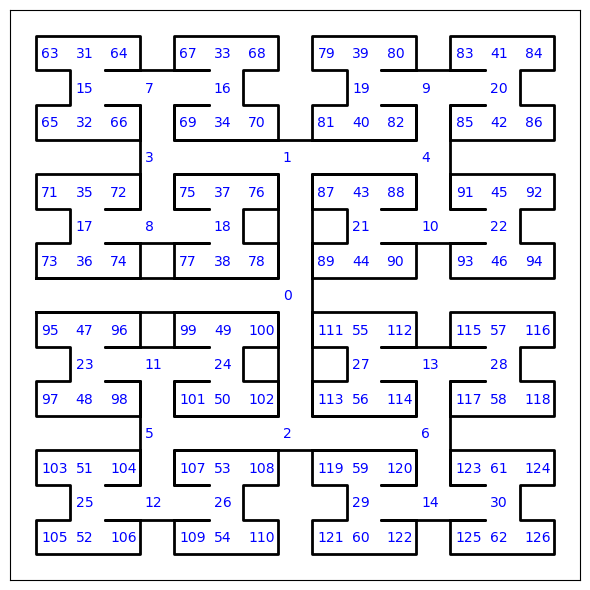

In [6]:
ma=NewMaze(6)
PlotMazeNodes(ma)

In [4]:
fig.savefig('outdata_for-paper/maze.pdf',bbox_inches="tight")

AttributeError: 'NoneType' object has no attribute 'savefig'

## Globals

In [17]:
terminals = np.arange(63,127)
terminal_mat = [1,0,0]
home_mat = [0,1/2,1/2]

# Main Functions

## Helpers

## Initialize

Policy defined as:

$$\pi(a|s) = \frac{e^{\beta E(s,a)}}{\sum_{a'}e^{\beta E(s,a')}}$$

$policy$ matrix shape is the same as E matrix shape (above).

$sta$ built as:
```
[
    [ # i = node number
        # node level (127 = home, 0 = 1,2 etc.)
        # left child node number
        # right child node number
    ]
]
```

In [17]:
NewTransMatrix(ma) # = sta

array([[127,   1,   2],
       [  0,   3,   4],
       [  0,   6,   5],
       [  1,   8,   7],
       [  1,   9,  10],
       [  2,  12,  11],
       [  2,  13,  14],
       [  3,  15,  16],
       [  3,  18,  17],
       [  4,  19,  20],
       [  4,  22,  21],
       [  5,  23,  24],
       [  5,  26,  25],
       [  6,  27,  28],
       [  6,  30,  29],
       [  7,  32,  31],
       [  7,  33,  34],
       [  8,  36,  35],
       [  8,  37,  38],
       [  9,  40,  39],
       [  9,  41,  42],
       [ 10,  44,  43],
       [ 10,  45,  46],
       [ 11,  48,  47],
       [ 11,  49,  50],
       [ 12,  52,  51],
       [ 12,  53,  54],
       [ 13,  56,  55],
       [ 13,  57,  58],
       [ 14,  60,  59],
       [ 14,  61,  62],
       [ 15,  63,  64],
       [ 15,  66,  65],
       [ 16,  67,  68],
       [ 16,  70,  69],
       [ 17,  71,  72],
       [ 17,  74,  73],
       [ 18,  75,  76],
       [ 18,  78,  77],
       [ 19,  79,  80],
       [ 19,  82,  81],
       [ 20,  83

In [18]:
def Init():
    '''
    initialize simulation, return E and policy matrix, and sta = matrix of nodes and their children.
    '''
    sta=NewTransMatrix(ma) # array of nodes connected to each node as such: index = parent node, [level, left child, right child]
    E=np.ones((len(ma.ru)+1,3)) # 2D array of values
    policy = np.full(E.shape,1/3)
    policy[terminals] = terminal_mat # reset terminal matrices
    policy[-1] = home_mat # reset home matrix
    return E,policy,sta

## Simulation Functions

Update E by:
$$ E(s,a) \leftarrow E(s,a) + \eta \left(-E(s,a) + \gamma E(s',a')\right) $$

In [19]:
def UpdateEStateAction(value0,value1,gamma,eta):
    return value0 + eta * (-value0 + gamma * value1)

In [20]:
def UpdatePolicyState(state,p_state,E_state,beta):
    if state not in terminals and state != 127:
        if beta <= 700:
            exp_beta_es=np.exp(E_state * beta)
            p_state=np.divide(exp_beta_es, exp_beta_es.sum(keepdims=True), out=np.zeros_like(exp_beta_es), where=exp_beta_es.sum(keepdims=True)!=0)
        else: # beta = infinity
            m = max(E_state)
            mi = np.where(E_state == m)[0]
            p_state = np.zeros(E_state.shape)
            p_state[mi] = 1/len(mi)
            
    return p_state

In [21]:
def UpdateEAndPolicy(E_state0,p_state0,state0,action0,value1,beta,gamma,eta):
    '''
    Updates the E and policy matrix. If beta > 700, assume beta=infinity
    state0 = node
    action0 = 0 - parent, 1 - left, 2 - right
    value1 = E(s',a')
    '''
    value0 = GetValueInState(E_state0,action0) # get E(s,a)
    E_state0[action0] += eta * (-value0 + gamma * value1) # update E(s,a)
    # update policy
    if state0 not in terminals and state0 != 127:
        if beta <= 700:
            exp_beta_es=np.exp(E_state0 * beta)
            p_state0=np.divide(exp_beta_es, exp_beta_es.sum(keepdims=True), out=np.zeros_like(exp_beta_es), where=exp_beta_es.sum(keepdims=True)!=0)
        else: # beta = infinity
            m = max(E_state0)
            mi = np.where(E_state0 == m)[0]
            p_state0 = np.zeros(E_state0.shape)
            p_state0[mi] = 1/len(mi)
            
    return E_state0[action0],p_state0
    

In [22]:
def UpdateEAndPolicy2(E,policy,state0,action0,state1,action1,beta,gamma,eta):
    '''
    Updates the E and policy matrix. If beta > 700, assume beta=infinity
    state0 = node
    action0 = 0 - parent, 1 - left, 2 - right
    value1 = E(s',a')
    action1 = -1 - simulation mode, find action, 0,1,2 - as in action0
    '''
    
    value0 = GetValue(E,state0,action0) # get E(s,a)
    
    if action0 > 0:
        value_back1 = GetValue(E,state1,0) # get E(s',0)
        E[state1][0] = UpdateEStateAction(value_back1,value0,gamma,eta) # update E(s',0)
        policy[state1] = UpdatePolicyState(state1,policy[state1],E[state1],beta) # update pi(s')
        
    # choose a' if simulation mode is on
    if action1 == -1:
        action1 = ChooseAction(policy,state1)
        
    value1 = GetValue(E,state1,action1) # get E(s',a')
    E[state0][action0] = UpdateEStateAction(value0,value1,gamma,eta) # update E(s,a)
    
    policy[state0] = UpdatePolicyState(state0,policy[state0],E[state0],beta) # update pi(s)
    
    return E,policy,action1
    

In [23]:
def ChooseAction(policy,state):
    '''
    choose next action by policy probabilities. returns **translated action**
    '''
    return int(np.random.choice(3,1,p=policy[state])[0])

Cross-Entropy estimation for unknown source distribution calculated by:

$$ -\frac{1}{n} \sum_{i=1}^{n} \log_2 \pi(a_i | s_i) = \left\langle -\log_2 \pi(a_i | s_i) \right\rangle_i $$

where $n$ is the number of steps where $\pi(a_i | s_i) \neq 0$ and $\pi$ is the policy derived from the simulation.

In [24]:
def CalculateCrossEntropy(da,mk,E,pr,beta,gamma,eta,sta,ma):
    '''
    Calculate cross-entropy
    da = data
    mk = mask applied to action, Boolean
    pr = probability array
    sta = node child matrix
    ma = maze
    '''
    #ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    acst = ConvertNodesToStatesActions(da,sta,ma)
    
    pt=[] # predicted probabilities for the observed action
    ptsa = []
    for i in range(len(da)): # i points to the action to be predicted
        if mk[i]:
            x = acst[i]
            sn = x[0]
            a = x[1]
            if i+1 < len(da):
                pt+=[pr[sn][a]] # add probability for the observed action to the list
                ptsa += [(sn,a,pr[sn][a])]
                x1 = acst[i+1]
                sn1 = x1[0]
                a1 = x1[1]
                value1 = GetValue(E,sn1,a1)
                E[sn][a],pr[sn] = UpdateEAndPolicy(E[sn],pr[sn],sn,a,value1,beta,gamma,eta)
                ptnp = np.array(pt)
                ce=-np.sum(np.log2(ptnp, out=-np.ones_like(pt), where=(ptnp!=0)))/len(ptnp) # cross-entropy
                ce_random = -np.sum(np.log2(1/3, out=-np.ones_like(ptnp), where=(ptnp!=0)))/len(ptnp) # cross-entropy
                #E,pr,_ = UpdateEAndPolicy2(E,pr,sn,a,sn1,a1,beta,gamma,eta)
    
    pt = np.array(pt)
    
    ### CHECK POINTS
    
    #pts = pt[pt!=0] # pt support
    #print(pts)
    #ce=-np.sum(np.log2(pts))/len(pts) # cross-entropy
    
    ce=-np.sum(np.log2(pt, out=-np.ones_like(pt), where=(pt!=0)))/len(pt) # cross-entropy
    
    return ce

$hist$ matrix built as:
```
[
    [ # i = number of bout
        (state, ta)
    ]
]
```
With $state=(sn,sd)$ and $ta$ is the translated action.

In [25]:
def Simulate(nbouts,E,policy,sta,beta=0.1,gamma=0.1,eta=0.1):
    '''
    simulate trajectories and return final E and policy matrices, and history
    nbouts = number of bouts (exploration until back to cage)
    E = E matrix
    policy = policy matrix
    sta = parents and children matrix
    '''
    hist = []
    state0 = 0
    action0 = ChooseAction(policy,state0)
    for i in range(nbouts):
        hist.append([])
        home = False # has the bout ended
        hist[i].append((state0,action0))
        while not home:
            state1 = sta[state0][action0] # state1 = next state node
            #action1 = ChooseAction(policy,state1)
            #value1 = GetValue(E,state1,action1) # get E(s',a')
            #print((state1,action1),E[state1])
            #E[state0][action0],policy[state0] = UpdateEAndPolicy(E[state0],policy[state0],state0,action0,value1,beta,gamma,eta)
            E,policy,action1 = UpdateEAndPolicy2(E,policy,state0,action0,state1,-1,beta,gamma,eta)
            state0 = state1
            action0 = action1
            
            if state1 == 127: # back to cage
                home = True
            else:
                hist[i].append((state0,action0))
            
    return E, policy, hist

In [1]:
def SimulateCrossEntropy(Names,beta,gamma,eta,ma):
    '''
    calculate cross entropy in accordance to every mouse in names, and return a list of cross entropies
    Names = list of nicknames of mice
    '''
    rew = False
    ces=[]
    for nickname in Names:
        E,policy,sta = Init()
        tf=LoadTraj(nickname+'-tf')
        # try
        dte=np.concatenate([b[:-2,0] for b in tf.no]) # test states
        #dte=np.concatenate([b[:-2,0] for b in tf.no]) # test states
        mte=np.array([True]+[True,]*(len(dte)-1)) # mask for testing, all actions OK except first
        mte[np.where(dte[:-1]>62)[0]]=False # mask for testing, eliminate end nodes
        ce = CalculateCrossEntropy(dte,mte,E,policy,beta,gamma,eta,sta,ma)
        ces.append(ce)
    
    return ces

## V3

In [27]:
def GetNextValue3(E,state):
    '''
    return E(s,a)
    action = 0 - parent, 1 - left, 2 - right
    '''
    return (E[state][1] + E[state][2])/2

In [28]:
def Init3():
    '''
    initialize simulation, return E and policy matrix, and sta = matrix of nodes and their children.
    '''
    sta=NewTransMatrix(ma) # array of nodes connected to each node as such: index = parent node, [level, left child, right child]
    E=np.ones((len(ma.ru)+1,3)) # 2D array of values
    E[:,0] = 0
    policy = E.copy()*1/2
    policy[terminals] = terminal_mat # reset terminal matrices
    policy[-1] = home_mat # reset home matrix
    return E,policy,sta

In [29]:
def UpdateEAndPolicy3(E,policy,state0,action0,state1,beta,gamma,eta):
    '''
    Updates the E and policy matrix. If beta > 700, assume beta=infinity
    state0 = node
    action0 = 0 - parent, 1 - left, 2 - right
    value1 = E(s',a')
    action1 = -1 - simulation mode, find action, 0,1,2 - as in action0
    '''
    
    if action0 != 0:
        value0 = GetValue(E,state0,action0) # get E(s,a)
        value1 = GetNextValue3(E,state1) # get E(s')
        E[state0][action0] = UpdateEStateAction(value0,value1,gamma,eta) # update E(s,a)
        E[state0][0] = max(1-((E[state0][1] + E[state0][2])/2),0)
        policy[state0] = UpdatePolicyState(state0,policy[state0],E[state0],beta) # update pi(s)
    else:
        if state0 in terminals:
            E[state0] = [0,eta * E[state0][1], eta * E[state0][2]]
            policy[state0] = [1,0,0]
    
    return E,policy
    

## Calculate Cross-Entropy Difference

In [30]:
def CalcCEDiff(da,mk,E,pr,beta,gamma,eta,sta,ma,mode,frame):
    '''
    Calculate cross-entropy
    da = data
    mk = mask applied to action, Boolean
    pr = probability array
    sta = node child matrix
    ma = maze
    '''
    #ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    acst = ConvertNodesToStatesActions(da,sta,ma)
    
    pt=[] # predicted probabilities for the observed action
    ce_rand = -np.log2(1/3)
    ces = []
    for i in range(len(da)): # i points to the action to be predicted
        x = acst[i]
        sn = x[0]
        a = x[1]
        if i+1 < len(da):
            if mk[i]:
                p = pr[sn][a]
                if p == 0:
                    p = 0.00000000001
                pt+=[p] # add probability for the observed action to the list
                
                j = len(pt)-1
                if (j % frame) == 0:
                    if j == 0:
                        ce = -np.log2(p)
                    else:
                        pt_frame = pt[j-frame+1:j+1]
                        ce_frame = -np.sum(np.log2(pt_frame, out=-np.ones_like(pt_frame), where=(pt_frame!=0))) # cross-entropy
                        ce = (ces[-1] * ((len(ces)-1) * frame + 1) + ce_frame) / (len(ces) * frame + 1)
                    ces += [ce]
            
            x1 = acst[i+1]
            sn1 = x1[0]
            a1 = x1[1]
            value1 = GetValue(E,sn1,a1)
            if mode == 1:
                E[sn][a],pr[sn] = UpdateEAndPolicy(E[sn],pr[sn],sn,a,value1,beta,gamma,eta)
            elif mode == 2:
                E,pr,_ = UpdateEAndPolicy2(E,pr,sn,a,sn1,a1,beta,gamma,eta)
            elif mode == 3:
                E,pr = UpdateEAndPolicy3(E,pr,sn,a,sn1,beta,gamma,eta)
                
    return ces

In [2]:
def CEDiff(Names,beta,gamma,eta,ma,mode,frame):
    '''
    calculate cross entropy in accordance to every mouse in names, and return a list of cross entropies
    Names = list of nicknames of mice
    '''
    rew = False
    ces_mult=[]
    for nickname in Names:
        if mode == 3:
            E,policy,sta = Init3()
        else:
            E,policy,sta = Init()
        tf=LoadTraj(nickname+'-tf')
        dte=np.concatenate([b[:-2,0] for b in tf.no]) # test states
        mte=np.array([True]+[True,]*(len(dte)-1)) # mask for testing, all actions OK except first
        mte[np.where(dte[:-1]>62)[0]]=False # mask for testing, eliminate end nodes
        ces = CalcCEDiff(dte,mte,E,policy,beta,gamma,eta,sta,ma,mode,frame)
        ces_mult.append(ces)
    
    return ces_mult

# End Nodes Visited

## Run Simulation

### Run Single Simulation

In [ ]:
eta=0.1
gamma=0.1
beta=1
nbouts = 1
E,policy,sta = Init()
E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)

### Run Multiple Simulations

In [ ]:
eta=0.1
gamma=0.1
betas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 100, 800]
nbouts = 100

bhist = np.ndarray(shape=(len(betas),2), dtype=object)
bhist[:,0] = betas

for j,beta in enumerate(betas): # run simulation on each beta
    E,policy,sta = Init()
    E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)
    bhist[j,-1] = hist

## Plot End Nodes Visited

In [ ]:
le=6 # end nodes level

# PLOT OPTIMAL
x=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64]
y=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64] 
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x,y,'-b',label='optimal')

# PLOT UNREWARDED MICE
for i,nickname in enumerate(UnrewNamesSub):
    with open('outdata/'+nickname+'-Modes1', 'rb') as f:
        nn1,nf1,tr1,wcn=pickle.load(f)
    x=wcn[1,:]
    y=wcn[2,:]
    ax.plot(x,y,'-c',linewidth=1)
plt.plot([], [], 'c', label="mice")

# PLOT SIMULATION
fhist = FlattenBHist(bhist) # flattened bhist
color = cm.rainbow(np.linspace(0, 1, len(betas)))

for i,row in enumerate(fhist):
    wcn = NewNodes(row,le)
    x=wcn[1]
    y=wcn[2]
    ax.plot(x,y,c=color[i], label='beta=' + str(bhist[i,0]))
    
# PLOT RANDOM
tf=LoadTraj('rw01-tf')
wcn=NewNodesMerge3(tf,ma,le)
x=wcn[1,:]
y=wcn[2,:]
ax.plot(x,y,'--k', linewidth=1.5,label='random')

ax.legend()
ax.set_xlabel('End node visited')
ax.set_ylabel('New end node found')
ax.set_xlim([1,5000])


# Cross-Entropy

## Calculate cross-entropy for each unrewarded mouse

### Calculate Once

In [ ]:
beta=1
gamma=0.1
eta=0.1
ce = SimulateCrossEntropy(UnrewNamesSub,beta,gamma,eta,ma)
print(ce)

### Calculate Multiple Times

In [ ]:
etas = np.linspace(0.1,1,9, endpoint=False)
gammas = np.linspace(0,1,10,endpoint=False)
betas1 = np.logspace(0.1,2,10,endpoint=False)
betas2 = np.linspace(100,800,8,endpoint=True)
betas = np.concatenate((betas1,betas2))
print(betas)

In [ ]:
unified_unrew_ce = np.zeros((len(betas),len(gammas),len(etas),len(UnrewNamesSub)))
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            print(beta, gamma, eta)
            ce = SimulateCrossEntropy(UnrewNamesSub,beta,gamma,eta,ma)
            unified_unrew_ce[b,g,e]=ce
            print(ce)
            
print(unified_unrew_ce)

### Load UNREW_CE

In [ ]:
uucsb = np.load('unified_unrew_ce_smallb.npy')
uucg0 = np.load('unified_unrew_ce_gamma0.npy')
uuc2 = np.load('unified_unrew_ce.npy')

In [ ]:
uuc_e=np.concatenate((uucg0,uuc2), axis=1)
uuc=np.concatenate((uucsb,uuc_e), axis=0)

In [ ]:
np.save('uuc', uuc)

### Calculate averages

In [ ]:
amin = np.unravel_index(np.argsort(uuc,axis=None), uuc.shape)
uuc_avg = np.mean(uuc, axis=3)
amin_avg = np.unravel_index(np.argsort(uuc_avg,axis=None), uuc_avg.shape)
amin_avg_tuples = [(uuc_avg[amin_avg[0][i],amin_avg[1][i],amin_avg[2][i]],
                    betas[amin_avg[0][i]],
                    gammas[amin_avg[1][i]],
                    etas[amin_avg[2][i]]) for i in range(len(amin_avg[0]))]
print(*amin_avg_tuples, sep='\n')

In [ ]:
with open('amin_avg_tuples.txt', 'w') as f:
    print(*amin_avg_tuples, sep='\n', file=f)

## Plot Cross-Entropy

In [ ]:
with open('outdata/Markov3-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    Names,ef,hf,ev,hv,eft,hft,evt,hvt=pickle.load(f) 

In [ ]:
all_ce = []
for _,name in enumerate(Names):
    if name not in UnrewNamesSub:
        all_ce.append(0)
    else:
        all_ce.append(uuc[UnrewNamesSub.index(name)])


In [ ]:
# Table of entropies from all methods for TJs and exploration
with open('outdata/BZentropies', 'rb') as f:
    _,en=pickle.load(f)  
with open('outdata/FixEntropies-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    _,ef=pickle.load(f)  
with open('outdata/VarEntropies-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    _,ev=pickle.load(f)  
with open('outdata/FourBiasEntropies-TJ1-EX1-Split5', 'rb') as f:
    _,eb=pickle.load(f) 
    
print('Entropy from Markov fits and 4-bias walk')
print('Restricted to T-junctions and exploration mode')
print('Markov fits pool over L vs R nodes in each level')
print('   fixed Markov  variable Markov  4-bias walk        Model')
for i in range(len(Names)):
    print(Names[i]+':    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
          format(ef[i],ev[i],eb[i],all_ce[i]))
print('------------------------------------------------------------')
print('Av:    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
      format(np.mean(ef),np.mean(ev),np.mean(eb),np.mean(uuc)))
print('SD:    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
      format(np.std(ef),np.std(ev),np.std(eb),np.std(uuc)))

In [ ]:
k=len(RewNames)
RN=np.array(RewNames)
UN=np.array(UnrewNamesSub)
ev=np.array(ev);ef=np.array(ef);eb=np.array(eb);en=np.array(en);ace=np.array(all_ce)
evr=ev[:k];efr=ef[:k];ebr=eb[:k];enr=en[:k]
evu=ev[k:];efu=ef[k:];ebu=eb[k:];enu=en[k:];aceu=ace[k:]
sir=np.argsort(evr)
siu=np.argsort(evu)
print('Limited to T-junctions during exploration, includes L vs R node pooling')
ax=plot(np.arange(len(UN)),[evu[siu],efu[siu],ebu[siu],aceu[siu]],
    fmts=['r_','g_','b_','y_'],markersize=6,markeredgewidth=3,
       figsize=(6,3.5),xlabel='unrewarded',ylabel='Cross-entropy (bits/action)');
plot([-0.5,len(UN)+1.5],[np.log(3)/np.log(2),np.log(3)/np.log(2)],
    fmts=['k:'],linewidth=1,ylim=[0,2.1],axes=ax);
plt.legend(['Markov variable','Markov fixed','Biased walk','Model','Random walk'],loc='lower right',ncol=2)
plt.xticks(list(np.arange(len(UN))),list(UN[siu]));

## Calculate cross-entropy between two simulations

In [ ]:
eta=0.1
gamma=0.1
beta=600
nbouts=100

# sim 1
E1,policy1,sta = Init()
E1,policy1,hist1 = Simulate(nbouts,E1,policy1,sta,beta,gamma,eta)

# sim 2
E2,policy2,_ = Init()
E2,policy2,hist2 = Simulate(nbouts,E2,policy2,sta,beta,gamma,eta)

print(CalculateCrossEntropy2P(policy1,policy2))
print(CalculateCrossEntropy2P(policy1,policy1))
print(CalculateCrossEntropy2P(policy2,policy2))


In [ ]:
print(-np.log2(1/(126*3)))

## Calculate Cross-Entropy Diff

In [33]:
beta, gamma, eta = (1,0.5,0.5)

In [107]:
ce = CEDiff(['B5'],beta,gamma,eta,ma,1,10)

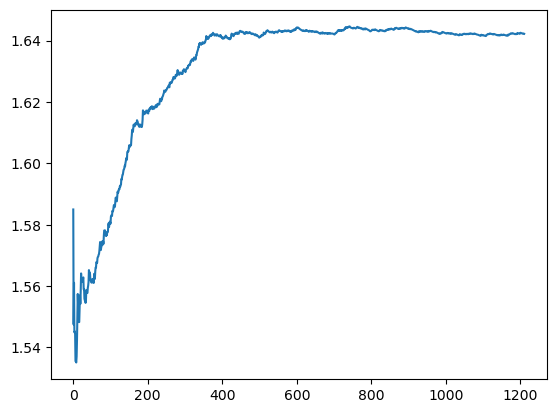

In [108]:
fig, ax = plt.subplots()

# PLOT CROSS-ENTROPY FOR MODE 1
x=range(len(ce[0]))
ax.plot(x,ce[0])

In [40]:
ce1 = CEDiff(UnrewNamesSub,beta,gamma,eta,ma,1)

In [41]:
ce2 = CEDiff(UnrewNamesSub,beta,gamma,eta,ma,2)

In [55]:
ce3 = CEDiff(UnrewNamesSub,beta,gamma,eta,ma,3)

In [50]:
uuc = np.load('uuc.npy')

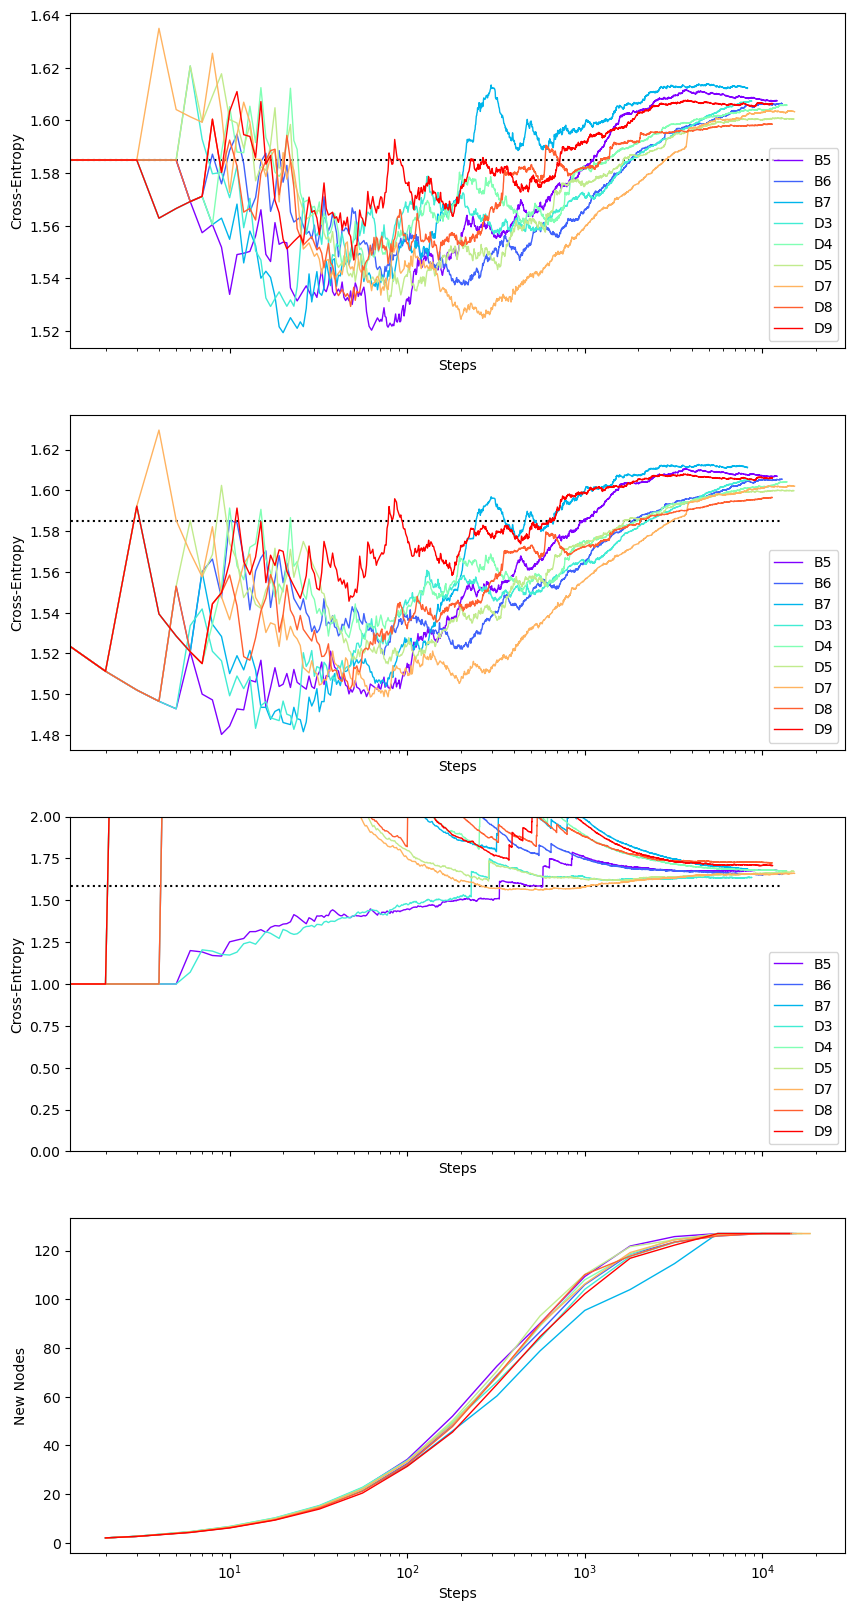

In [57]:
ce_rand = -np.log2(1/3)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,sharex='col')
color = cm.rainbow(np.linspace(0, 1, len(ce1)))

# PLOT CROSS-ENTROPY FOR MODE 1
ax1.hlines(y=ce_rand, xmin=0, xmax=12500, linestyle=':', color='k')
for i,mouse_ce in enumerate(ce1):
    x=range(len(mouse_ce))
    ax1.plot(x,mouse_ce,color=color[i],label=UnrewNamesSub[i],linewidth=1);

# PLOT CROSS-ENTROPY FOR MODE 2
ax2.hlines(y=ce_rand, xmin=0, xmax=12500, linestyle=':', color='k')
for i,mouse_ce in enumerate(ce2):
    x=range(len(mouse_ce))
    ax2.plot(x,mouse_ce,color=color[i],label=UnrewNamesSub[i],linewidth=1);
    
# PLOT CROSS-ENTROPY FOR MODE 3
ax3.hlines(y=ce_rand, xmin=0, xmax=12500, linestyle=':', color='k')
for i,mouse_ce in enumerate(ce3):
    x=range(len(mouse_ce))
    ax3.plot(x,mouse_ce,color=color[i],label=UnrewNamesSub[i],linewidth=1);
    
# PLOT NEW END-NODES
for i,nickname in enumerate(UnrewNamesSub):
    tf = LoadTraj(nickname+'-tf')
    dte = np.concatenate([b[:-2,0] for b in tf.no]) # test states
    wcn = NewNodes4(dte)
    x=wcn[1,:]
    y=wcn[2,:]
    ax4.plot(x,y,color=color[i],label=nickname,linewidth=1)


ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Cross-Entropy')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Cross-Entropy')
ax3.set_xlabel('Steps')
ax3.set_ylabel('Cross-Entropy')
ax3.set_ylim([0,2])
ax4.set_xlabel('Steps')
ax4.set_ylabel('New Nodes')
ax4.set_xscale('log')
fig.set_figheight(20)
fig.set_figwidth(10)


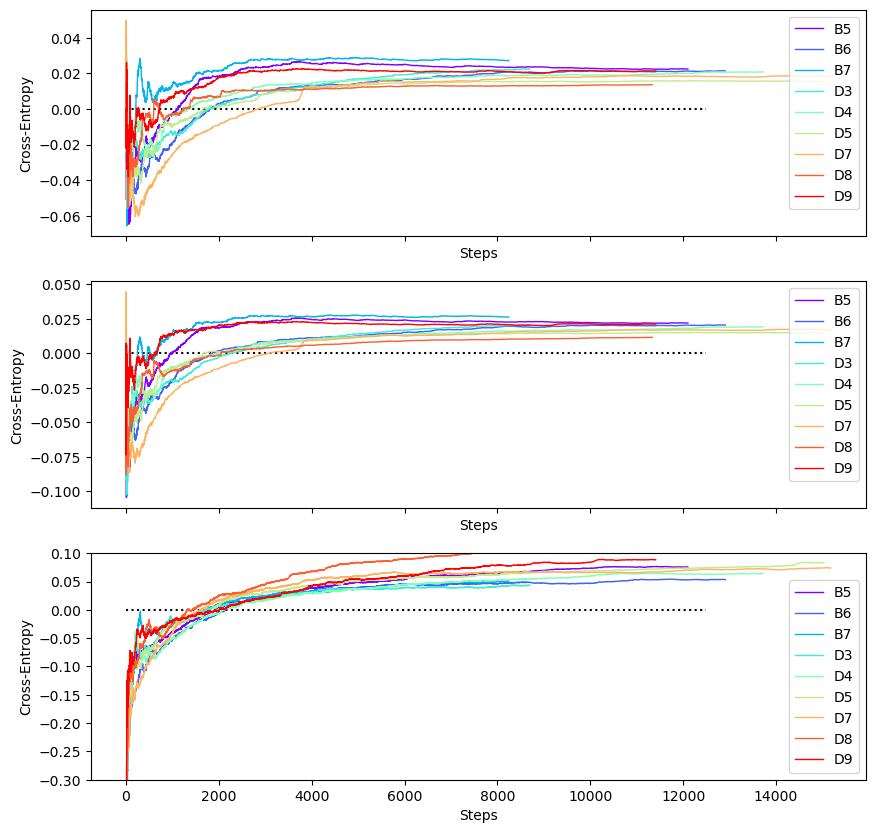

In [211]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex='col')
color = cm.rainbow(np.linspace(0, 1, len(ce)))

# PLOT CROSS-ENTROPY FOR MODE 1
ax1.hlines(y=0, xmin=0, xmax=12500, linestyle=':', color='k')
for i,diff in enumerate(ce_diff1):
    x=range(len(diff))
    ax1.plot(x,diff,color=color[i],label=UnrewNamesSub[i],linewidth=1);
    
# PLOT CROSS-ENTROPY FOR MODE 2
ax2.hlines(y=0, xmin=0, xmax=12500, linestyle=':', color='k')
for i,diff in enumerate(ce_diff2):
    x=range(len(diff))
    ax2.plot(x,diff,color=color[i],label=UnrewNamesSub[i],linewidth=1);
    
# PLOT CROSS-ENTROPY FOR MODE 3
ax3.hlines(y=0, xmin=0, xmax=12500, linestyle=':', color='k')
for i,diff in enumerate(ce_diff3):
    x=range(len(diff))
    ax3.plot(x,diff,color=color[i],label=UnrewNamesSub[i],linewidth=1);

ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Cross-Entropy')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Cross-Entropy')
ax3.set_xlabel('Steps')
ax3.set_ylabel('Cross-Entropy')
#ax1.set_xlim([1,3000])
#ax2.set_xlim([1,3000])
#ax3.set_xlim([1,3000])
ax3.set_ylim([-0.3,0.1])
fig.set_figheight(10)
fig.set_figwidth(10)


In [232]:
etas = np.linspace(0.1,1,3, endpoint=False)
gammas = np.linspace(0.1,1,3,endpoint=False)
betas1 = np.logspace(0.1,2,3,endpoint=False)
betas2 = np.linspace(100,800,2,endpoint=False)
betas = np.concatenate((betas1,betas2))
mice = ['B5']

In [235]:
ce_arr = np.ndarray(shape=(len(betas),len(gammas),len(etas)), dtype='object')
ce_diff_arr = np.ndarray(shape=(len(betas),len(gammas),len(etas)), dtype='object')

for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            ce,ce_diff = CEDiff(mice,beta,gamma,eta,ma,1)
            ce_arr[b,g,e] = ce
            ce_diff_arr[b,g,e] = ce_diff

In [241]:
np.save('ce_diff_B5_1', ce_diff_arr)

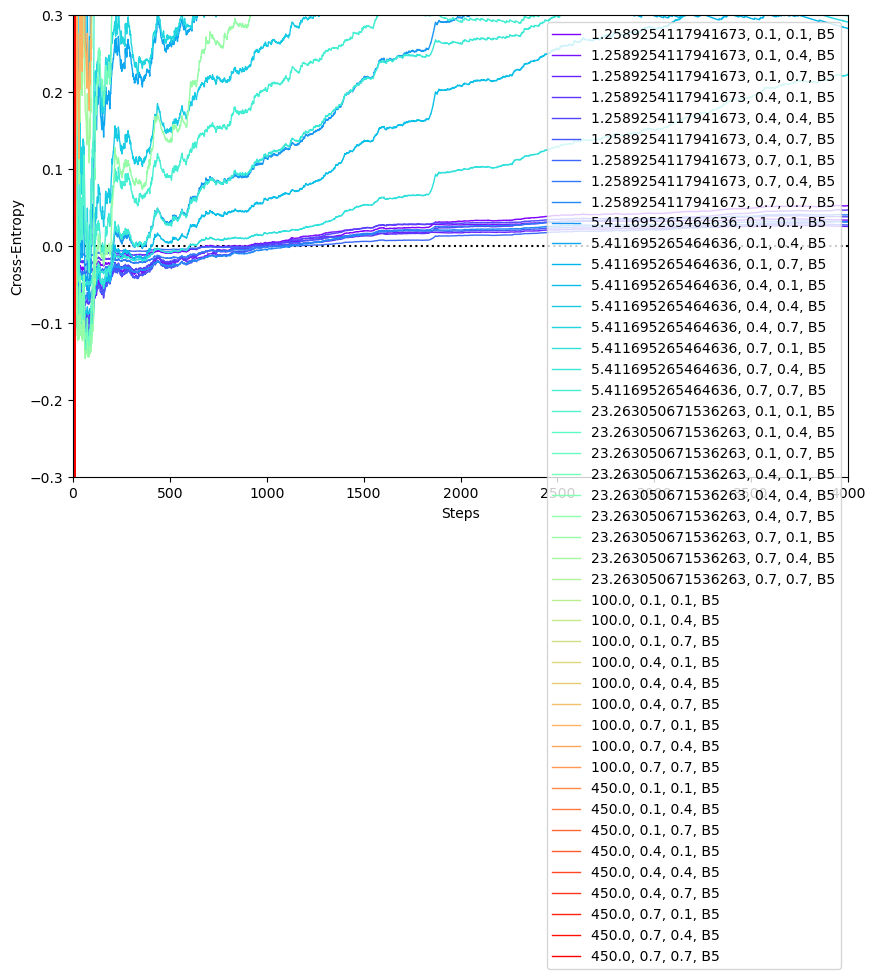

In [239]:
fig, ax = plt.subplots()
color = cm.rainbow(np.linspace(0, 1, ce_diff_arr.size))

# PLOT CROSS-ENTROPY FOR MODE 1
ax.hlines(y=0, xmin=0, xmax=12500, linestyle=':', color='k')
j = 0
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            for i,diff in enumerate(ce_diff_arr[b,g,e]):
                x=range(len(diff))
                ax.plot(x,diff,color=color[j],label=str(beta)+', '+str(gamma)+', '+str(eta)+', '+ mice[i],linewidth=1)
                j+=1
    
ax.legend()
ax.set_xlabel('Steps')
ax.set_ylabel('Cross-Entropy')
ax.set_xlim([0,4000])
ax.set_ylim([-0.3,0.3])
fig.set_figheight(6)
fig.set_figwidth(10)

In [245]:
ce_arr = np.ndarray(shape=(len(betas),len(gammas),len(etas)), dtype='object')
ce_diff_arr = np.ndarray(shape=(len(betas),len(gammas),len(etas)), dtype='object')

for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            ce,ce_diff = CEDiff(mice,beta,gamma,eta,ma,2)
            ce_arr[b,g,e] = ce
            ce_diff_arr[b,g,e] = ce_diff

In [247]:
np.save('ce_diff_B5_2', ce_diff_arr)

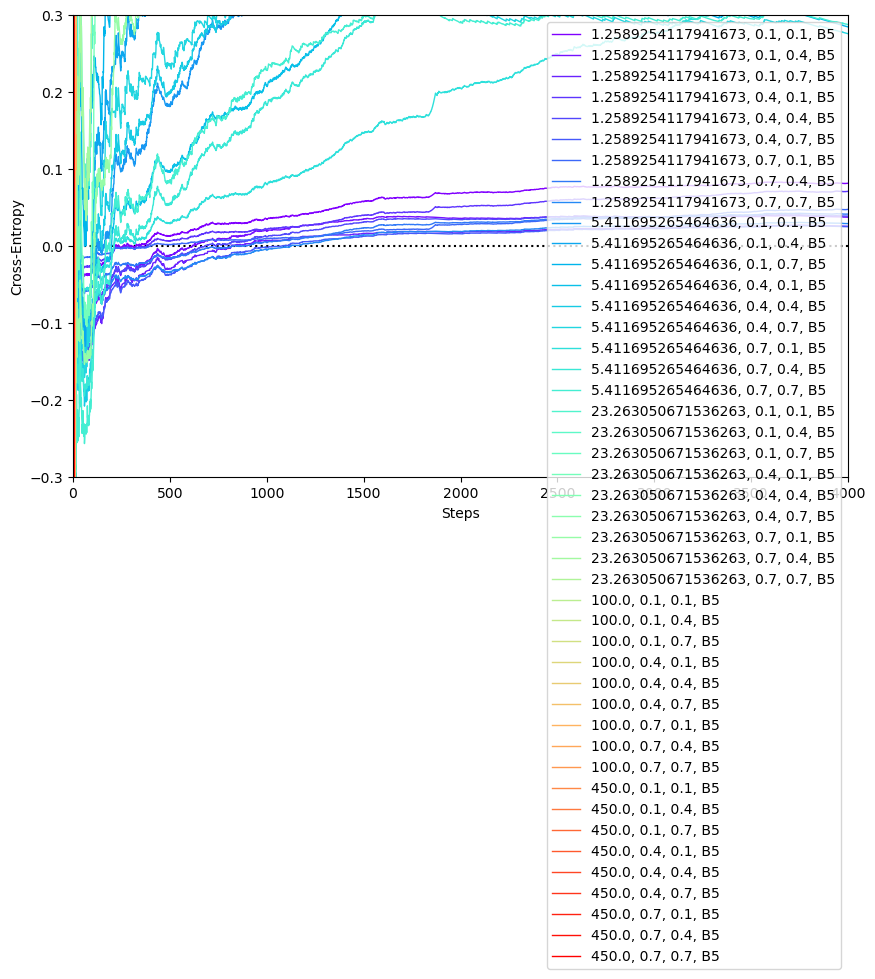

In [246]:
fig, ax = plt.subplots()
color = cm.rainbow(np.linspace(0, 1, ce_diff_arr.size))

# PLOT CROSS-ENTROPY FOR MODE 2
ax.hlines(y=0, xmin=0, xmax=12500, linestyle=':', color='k')
j = 0
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            for i,diff in enumerate(ce_diff_arr[b,g,e]):
                x=range(len(diff))
                ax.plot(x,diff,color=color[j],label=str(beta)+', '+str(gamma)+', '+str(eta)+', '+ mice[i],linewidth=1)
                j+=1
    
ax.legend()
ax.set_xlabel('Steps')
ax.set_ylabel('Cross-Entropy')
ax.set_xlim([0,4000])
ax.set_ylim([-0.3,0.3])
fig.set_figheight(6)
fig.set_figwidth(10)

In [248]:
ce_arr = np.ndarray(shape=(len(betas),len(gammas),len(etas)), dtype='object')
ce_diff_arr = np.ndarray(shape=(len(betas),len(gammas),len(etas)), dtype='object')

for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            ce,ce_diff = CEDiff(mice,beta,gamma,eta,ma,3)
            ce_arr[b,g,e] = ce
            ce_diff_arr[b,g,e] = ce_diff

In [250]:
np.save('ce_diff_B5_3', ce_diff_arr)

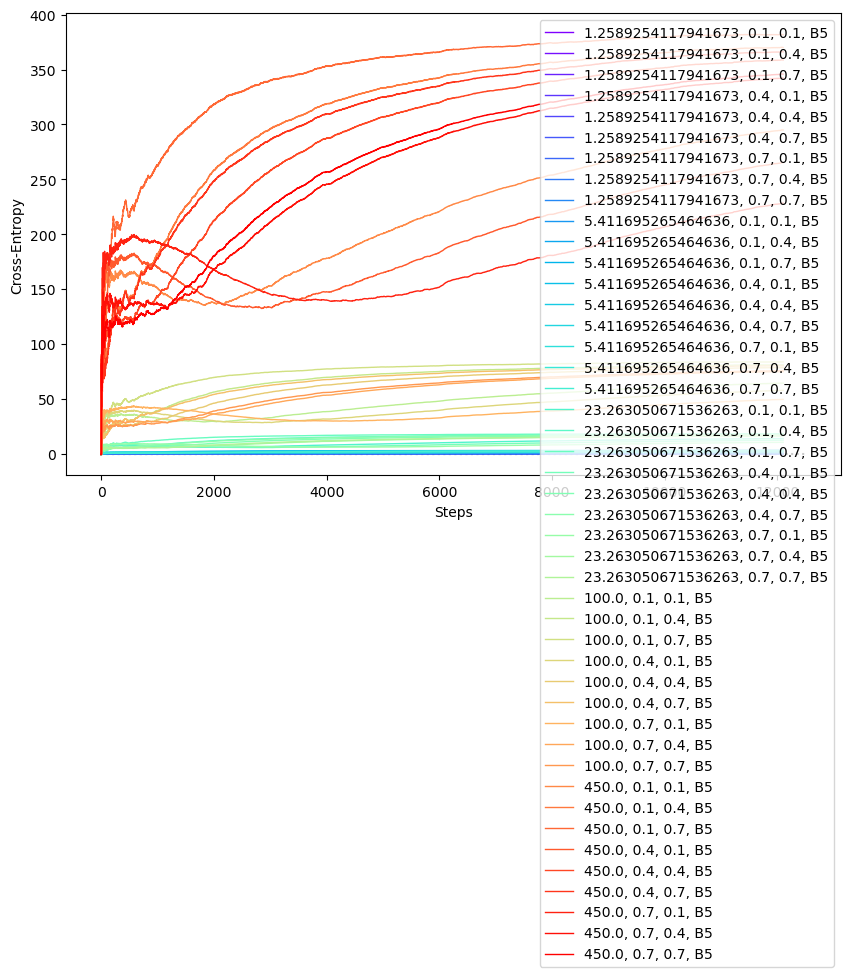

In [252]:
fig, ax = plt.subplots()
color = cm.rainbow(np.linspace(0, 1, ce_diff_arr.size))

# PLOT CROSS-ENTROPY FOR MODE 3
ax.hlines(y=0, xmin=0, xmax=12500, linestyle=':', color='k')
j = 0
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            for i,diff in enumerate(ce_diff_arr[b,g,e]):
                x=range(len(diff))
                ax.plot(x,diff,color=color[j],label=str(beta)+', '+str(gamma)+', '+str(eta)+', '+ mice[i],linewidth=1)
                j+=1
    
ax.legend()
ax.set_xlabel('Steps')
ax.set_ylabel('Cross-Entropy')
#ax.set_xlim([0,4000])
#ax.set_ylim([-0.3,0.3])
fig.set_figheight(6)
fig.set_figwidth(10)

# Calculate Everything for 1 Mouse

## New Nodes

In [ ]:
mouse = 'B1'
etas = np.linspace(0.1,1,2, endpoint=False)
gammas = np.linspace(0,1,2,endpoint=False)
betas1 = np.logspace(0.1,2,2,endpoint=False)
betas2 = np.linspace(100,800,2,endpoint=True)
betas = np.concatenate((betas1,betas2))
#betas = [10]
nbouts = 25
le=6 # end nodes level

In [ ]:
# END NODES VISITED

mouse_hist = np.ndarray(shape=(len(betas),len(gammas),len(etas)), dtype='object')
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            print(beta, gamma, eta)
            E,policy,sta = Init()
            E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)
            fhist = FlattenHist(hist)
            wcn = NewNodes(fhist,le)
            x=wcn[1]
            y=wcn[2]
            mouse_hist[b,g,e]=(x,y)
            print(x,y)

In [ ]:
np.save('mouse_hist_25bouts', mouse_hist)

In [ ]:
# PLOT OPTIMAL
x=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64]
y=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64] 
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x,y,'-b',label='optimal')

# PLOT MOUSE
with open('outdata/'+mouse+'-Modes1', 'rb') as f:
    nn1,nf1,tr1,wcn=pickle.load(f)
x=wcn[1,:]
y=wcn[2,:]
ax.plot(x,y,'-c',linewidth=1)
plt.plot([], [], 'c', label="mice")

color = cm.rainbow(np.linspace(0, 1, mouse_hist.size))

i=0
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            x = mouse_hist[b,g,e][0]
            y = mouse_hist[b,g,e][1]
            ax.plot(x,y,c=color[i])
            i+=1
            
#label='b=' + str(beta) + 'g=' + str(gamma) + 'e=' + str(eta)
    
# PLOT RANDOM
tf=LoadTraj('rw01-tf')
wcn=NewNodesMerge3(tf,ma,le)
x=wcn[1,:]
y=wcn[2,:]
ax.plot(x,y,'--k', linewidth=1.5,label='random')

ax.legend()
ax.set_xlabel('End node visited')
ax.set_ylabel('New end node found')
ax.set_xlim([1,5000])

### Calculate closest simulation

In [ ]:
# mouse data

with open('outdata/'+mouse+'-Modes1', 'rb') as f:
    nn1,nf1,tr1,wcn=pickle.load(f)
x=wcn[1,:]
y=wcn[2,:]

dmin = 10000
dminarg = (0,0,0)
dminindex = (0,0,0)
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            xs = ResizeList(mouse_hist[b,g,e][0], len(x))
            ys = ResizeList(mouse_hist[b,g,e][1], len(y)) 
            dx = xs-x
            dy = ys-y
            dmin1 = min(dmin, abs(np.mean(dy)))
            if dmin1 < dmin:
                dminarg = (beta, gamma, eta)
                dminindex = (b,g,e)
                dmin = dmin1
            
print(dmin)
print(dminarg)
            

In [ ]:
# PLOT OPTIMAL
x=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64]
y=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64] 
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x,y,'-b',label='optimal')

# PLOT MOUSE
with open('outdata/'+mouse+'-Modes1', 'rb') as f:
    nn1,nf1,tr1,wcn=pickle.load(f)
x=wcn[1,:]
y=wcn[2,:]
ax.plot(x,y,'-c',linewidth=1)
plt.plot([], [], 'c', label="mice")

# PLOT CLOSEST SIM
color = cm.rainbow(np.linspace(0, 1, mouse_hist.size))
b,g,e = dminindex
x = mouse_hist[b,g,e][0]
y = mouse_hist[b,g,e][1]
ax.plot(x,y,c='purple')
            
#label='b=' + str(beta) + 'g=' + str(gamma) + 'e=' + str(eta)
    
# PLOT RANDOM
tf=LoadTraj('rw01-tf')
wcn=NewNodesMerge3(tf,ma,le)
x=wcn[1,:]
y=wcn[2,:]
ax.plot(x,y,'--k', linewidth=1.5,label='random')

ax.legend()
ax.set_xlabel('End node visited')
ax.set_ylabel('New end node found')
ax.set_xlim([1,5000])

## Cross-Entropy of Closest Simulation

In [ ]:
beta, gamma, eta = dminarg
ce = SimulateCrossEntropy(['B6'],1,0.5,0.5,ma)
print(ce)

In [ ]:
# CROSS ENTROPY

mouse_ce = np.zeros((len(betas),len(gammas),len(etas)))
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            ce = SimulateCrossEntropy([mouse],beta,gamma,eta,ma)
            mouse_ce[b,g,e]=ce[0]

In [ ]:
amin = np.unravel_index(np.argsort(uuc,axis=None), uuc.shape)
print(amin)

# Full Simulation

In [80]:
def ConvertIndicesToBGE(indices,betas,gammas,etas):
    return (round(betas[indices[0]],1),round(gammas[indices[1]],1),round(etas[indices[2]],1))

In [120]:
def PlotMult(Names,fstr,betas,gammas,etas,frame,mode):
    fig, axs = plt.subplots(len(Names),1,sharex='col')
    axs2 = []

    color = cm.rainbow(np.linspace(0, 1, size))
    color_names = cm.rainbow(np.linspace(0, 1, len(Names)))

    # PLOT CROSS-ENTROPY FOR MODE 1
    ce_rand = -np.log2(1/3)
    for i,nickname in enumerate(Names):
        ces = np.load(EvalStr(fstr,nickname), allow_pickle=True)

        tf = LoadTraj(nickname+'-tf')
        dte = np.concatenate([b[:-2,0] for b in tf.no]) # test states
        wcn = NewNodes4(dte)
        x=wcn[1,:]
        y=wcn[2,:]

        axs2.append(axs[i].twinx())  # instantiate a second Axes that shares the same x-axis
        axs2[i].set_ylabel('New Nodes')  # we already handled the x-label with ax1
        axs2[i].plot(x,y,color='black',linewidth=2)

        axs[i].hlines(y=ce_rand, xmin=0, xmax=10000, linestyle=':', color='k')
        axs[i].xaxis.set_tick_params(labelbottom=True)
        axs[i].set_xscale('log')
        axs[i].set_xlabel('Steps')
        axs[i].set_ylabel('Cross Entropy')
        axs[i].set_title(nickname)
        j=0
        for b,beta in enumerate(betas):
            for g,gamma in enumerate(gammas):
                for e,eta in enumerate(etas):
                    x=np.array(range(len(ces[b,g,e])))*10
                    axs[i].plot(x,ces[b,g,e],color=color[j],label=str(round(beta,2))+','+str(round(gamma,2))+','+str(round(eta,2)),alpha=0.1,linewidth=1)
                    j += 1

    axs[0].set_xscale('log')
    axs[0].set_xlim([10,10000])
    fig.set_figheight(50)
    fig.set_figwidth(15)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    return fig,axs

In [121]:
def PlotMin(Names,fstr,betas,gammas,etas,frame,mode):
    fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
    color = cm.rainbow(np.linspace(0, 1, len(Names)))
    text = '    (beta, gamma, eta) \n'

    for i,nickname in enumerate(Names):
        ces = np.load(EvalStr(fstr,nickname), allow_pickle=True)
        text = text + nickname + ': '

        min_value = float('inf')
        min_avg_value = float('inf')
        min_index = None
        min_avg_index = None
        for b,beta in enumerate(betas):
            for g,gamma in enumerate(gammas):
                for e,eta in enumerate(etas):
                    # Get the minimum value in the current list
                    current_min = min(ces[b,g,e])
                    current_avg = np.mean(ces[b,g,e])
                    # Check if it's the smallest we've found so far
                    if current_min < min_value:
                        min_value = current_min
                        min_index = [b,g,e]
                    if current_avg < min_avg_value:
                        min_avg_value = current_avg
                        min_avg_index = [b,g,e]

        x=np.array(range(len(ces[b,g,e])))*10
        b,g,e = min_index
        ba,ga,ea = min_avg_index
        text = text + str(ConvertIndicesToBGE(min_avg_index,betas,gammas,etas)) + '\n'

        ax1.plot(x,ces[ba,ga,ea],color=color[i],label=nickname,linewidth=1)

        tf = LoadTraj(nickname+'-tf')
        dte = np.concatenate([b[:-2,0] for b in tf.no]) # test states
        wcn = NewNodes4(dte)
        x=wcn[1,:]
        y=wcn[2,:]
        ax2.plot(x,y,color=color[i],linewidth=1,label=nickname)

    ax1.hlines(y=ce_rand, xmin=0, xmax=10000, linestyle=':', color='k')
    ax1.set_xscale('log')
    ax1.set_xlim([10,10000])
    ax1.set_title('Minimum (in average) Cross Entropy')
    ax1.set_ylabel('Cross Entropy')
    ax1.set_xlabel('Steps')
    ax1.legend()
    ax2.set_title('New Nodes as a Function of Steps')
    ax2.set_ylabel('New Nodes')
    ax2.set_xlabel('Steps')
    ax2.legend()

    fig.text(0.5,-0.12,text,horizontalalignment='center')
    fig.set_figheight(10)
    fig.set_figwidth(15)

    return fig,(ax1,ax2)

In [ ]:
'outdata_DORA/'+nickname+'_ces_'+str(frame)+'frame_'+str(mode)+'.npy'

In [114]:
def OutCEs(betas,gammas,etas,frame,mode):
    for nickname in UnrewNamesSub:
        ce_arr = np.ndarray(shape=(len(betas),len(gammas),len(etas)), dtype='object')
        for b,beta in enumerate(betas):
            for g,gamma in enumerate(gammas):
                for e,eta in enumerate(etas):
                    ce = CEDiff([nickname],beta,gamma,eta,ma,mode,frame)
                    ce_arr[b,g,e] = ce[0]
                
        np.save('outdata_DORA/'+nickname+'_ces_'+str(frame)+'frame_'+str(mode),ce_arr)

In [126]:
etas = np.linspace(0.1,1,10, endpoint=True)
print(etas)
gammas = np.linspace(0,1,11,endpoint=True)
print(gammas)
betas = np.linspace(0.2,2,10,endpoint=True)
print(betas)
frame = 10
size = len(betas) * len(gammas) * len(etas)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


### Mode = 1

In [109]:
fig,_ = PlotMult(betas,gammas,etas,frame,1)

In [ ]:
fig.savefig('outdata_DORA/Cross-Entropy_Steps_New-Nodes_1.png')

AttributeError: 'NoneType' object has no attribute 'savefig'

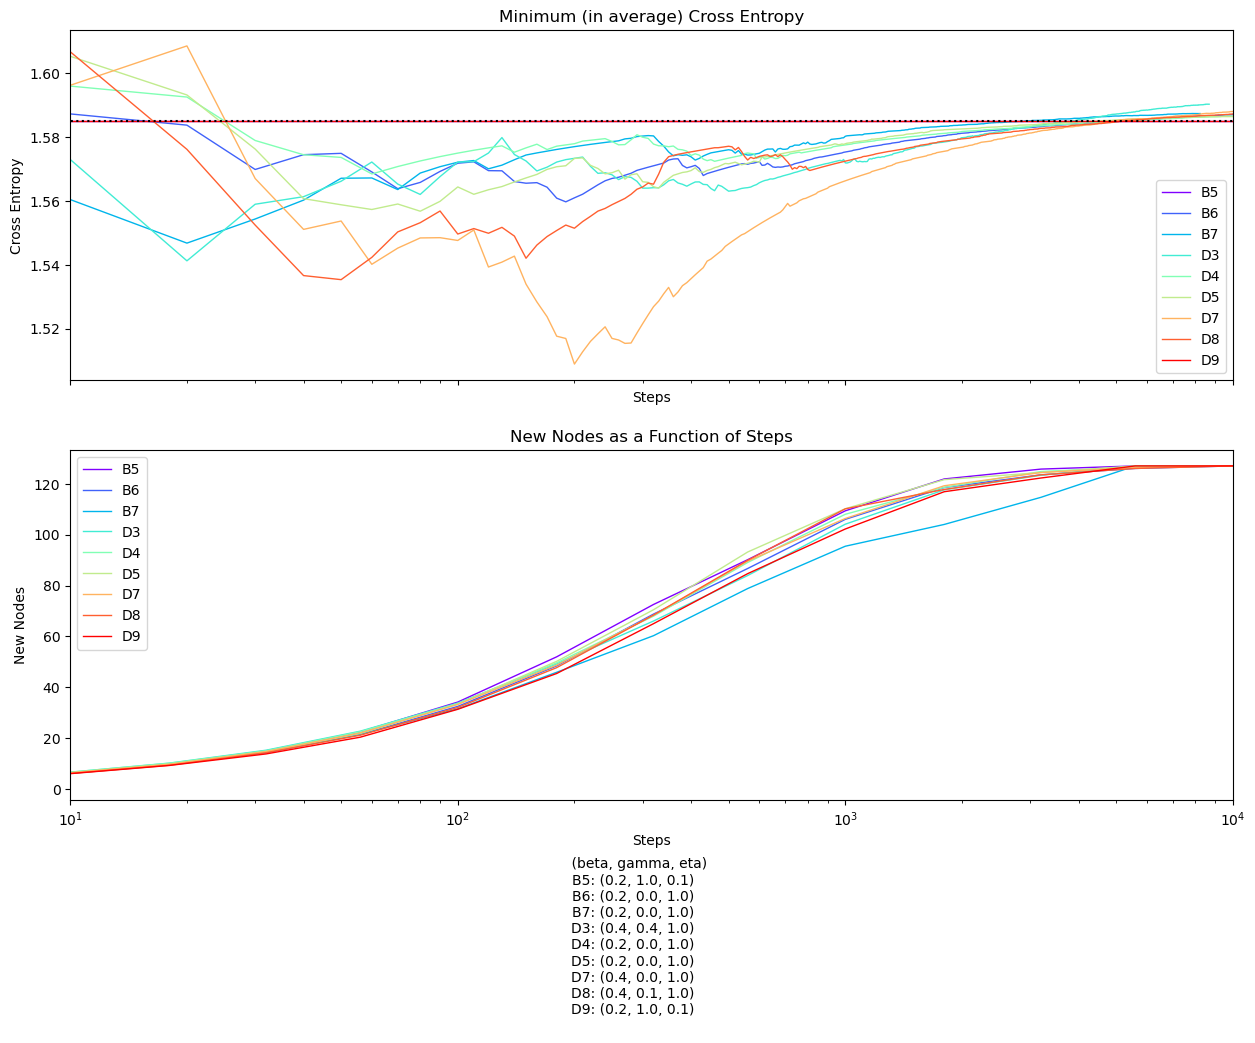

In [115]:
fig,_ = PlotMin(betas,gammas,etas,frame,1)

In [ ]:
fig.savefig('outdata_DORA/Minimum-Cross-Entropy_Steps_1.png',bbox_inches="tight")

### Mode = 2

In [3]:
OutCEs(betas,gammas,etas,frame,1)

NameError: name 'OutCEs' is not defined

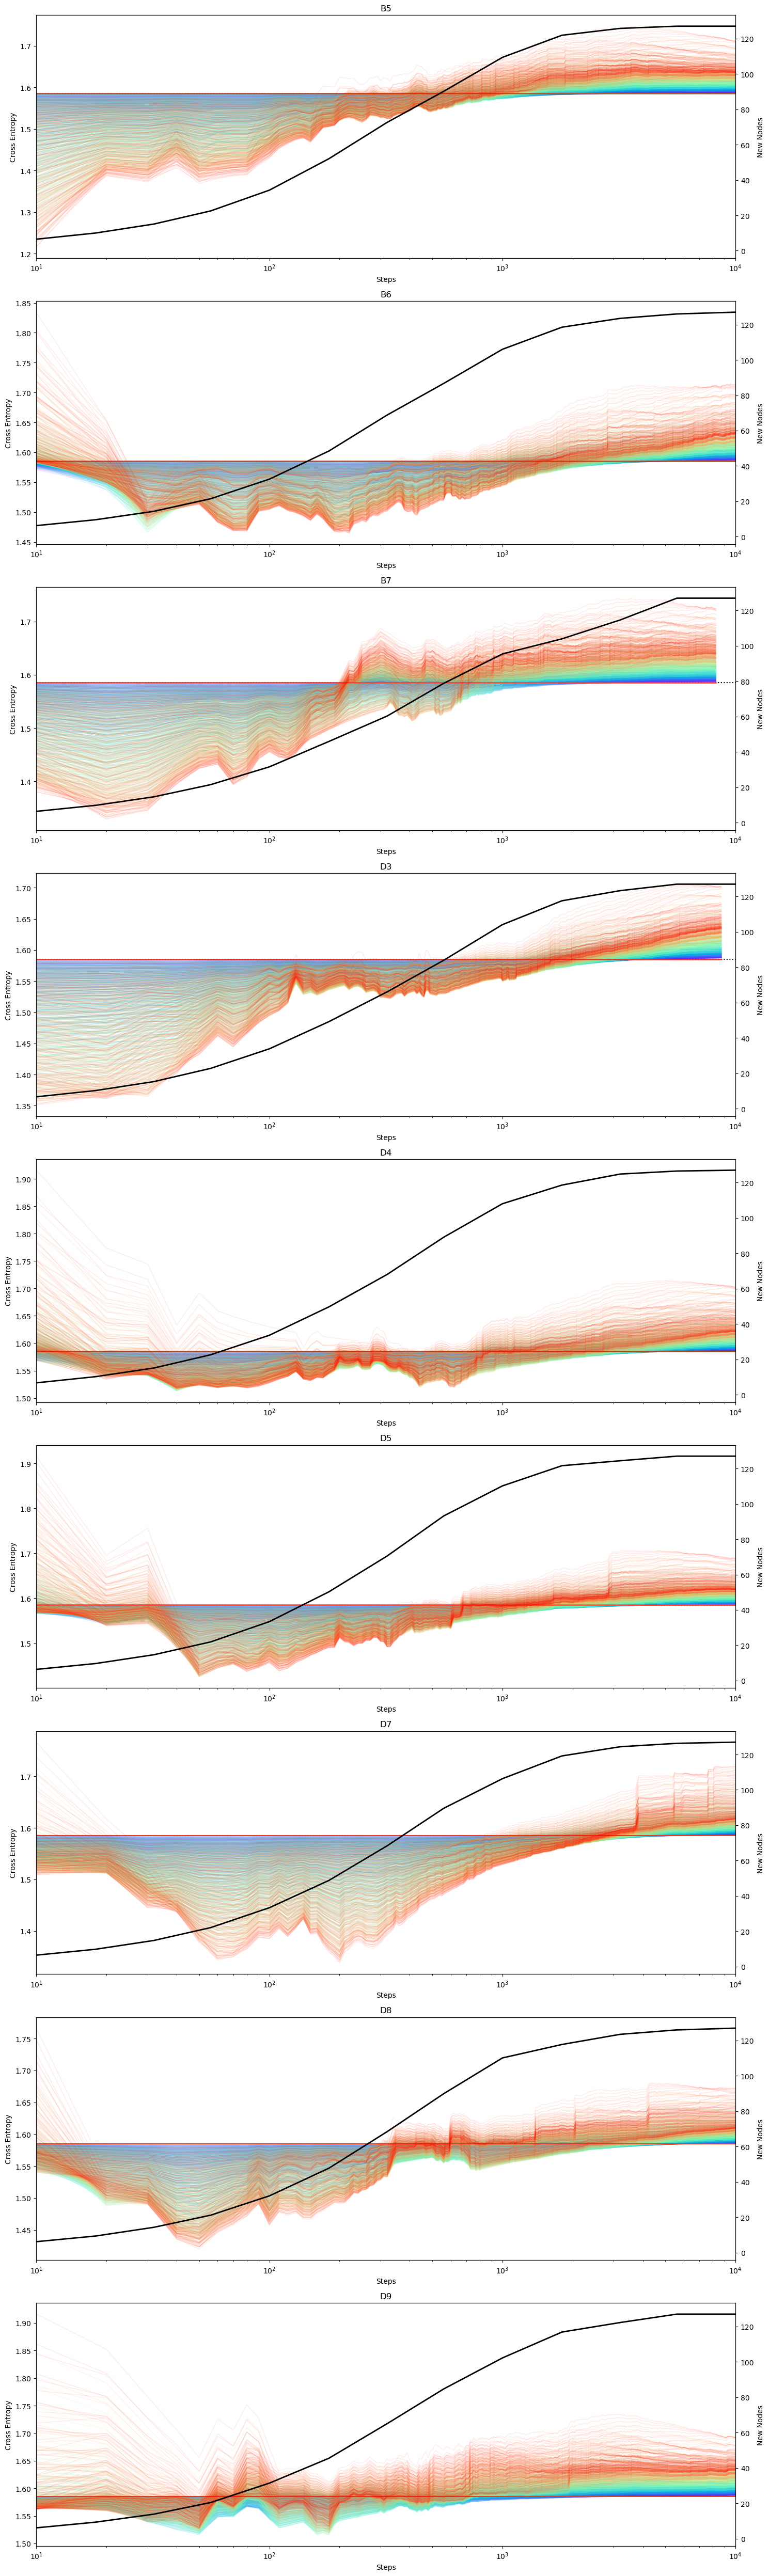

In [122]:
fig,_ = PlotMult(betas,gammas,etas,frame,2)

In [123]:
fig.savefig('outdata_DORA/Cross-Entropy_Steps_New-Nodes_2.png')

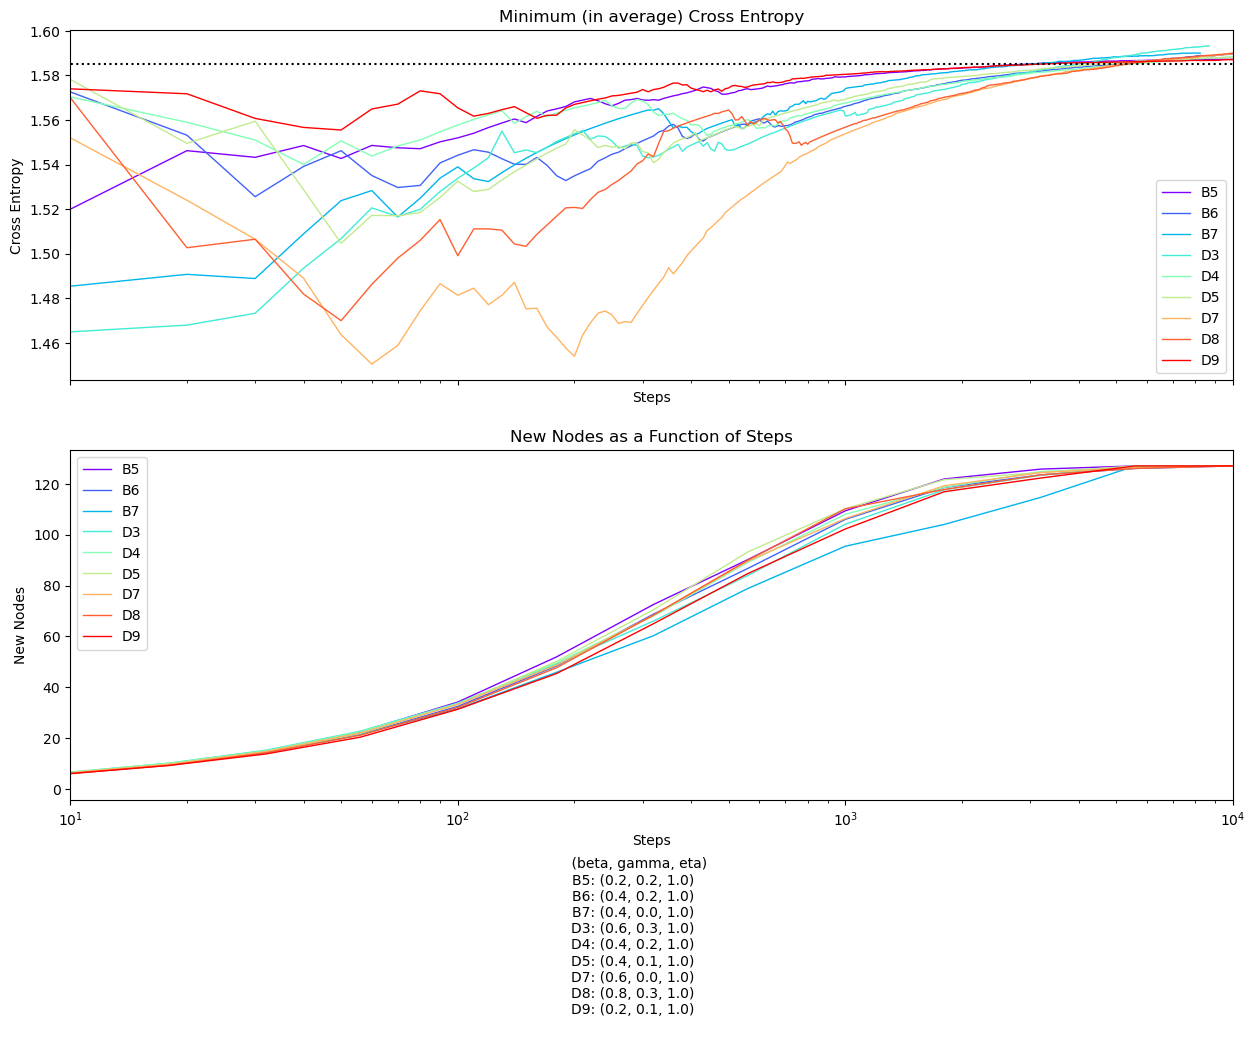

In [124]:
fig,_ = PlotMin(betas,gammas,etas,frame,2)

In [125]:
fig.savefig('outdata_DORA/Minimum-Cross-Entropy_Steps_2.png',bbox_inches="tight")